In [ ]:
import os
import warnings
import uuid
from dotenv import load_dotenv

from typing import Annotated, List
from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_huggingface import ChatHuggingFace, HuggingFaceEmbeddings
from pydantic import BaseModel, Field
from IPython.display import display, Image
from langchain.schema import Document
from langchain import hub

from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableConfig, RunnablePassthrough, RunnableLambda
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [2]:
load_dotenv()

os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
# os.environ["HF_HOME"] = "./cache/"

In [3]:
# 1단계 : 문서 로드
loader = PyMuPDFLoader("SPRI_AI_Brief_2023년12월호_F.pdf")
docs = loader.load()

# 2단계 : 문서 분할
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
split_documents = text_splitter.split_documents(docs)

# 3단계 : 임베딩
hf_embeddings = HuggingFaceEmbeddings(
    model_name = "BAAI/bge-m3",
    model_kwargs = {"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True}
)

# 4단계 : 벡터스토어 저장/불러오기
try:
    vectorstore = FAISS.load_local(
        folder_path="faiss_db",
        index_name="faiss_index",
        embeddings=hf_embeddings,
        allow_dangerous_deserialization=True,
    )
except:
    vectorstore = FAISS.from_documents(split_documents, hf_embeddings)
    vectorstore.save_local("faiss_db", "faiss_index")

# vectorstore.add_documents(new_split_documents)
# vectorstore.save_local("faiss_db", "faiss_index")

# 5단계 : 검색기 Retriever 생성
retriever = vectorstore.as_retriever()

# 6단계 : 프롬프트
prompt = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
You must include `page` number in your answer.
Answer in Korean.

#Question:
{question}

#Context:
{context}

#Answer:"""
)

# 7단계 : LLM 생성
# llm = ChatOpenAI(model_name="gpt-5-nano", temperature=0, api_key=os.getenv("OPENAI_API_KEY"))
llm = ChatOllama(model="gpt-oss:20b", temperature=0, base_url="http://localhost:11434")

# 8단계 : chain 생성
def format_docs(docs):
    return "\n\n".join(
        f"[page {d.metadata.get('page', 0) + 1}] {d.page_content}" for d in docs
    )

chain = (
    {"context":retriever | RunnableLambda(format_docs), "question":RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [4]:
# chain 실행
question = "삼성전자가 자체 개발한 AI 의 이름은?"
response = chain.invoke(question)
print(response)

삼성전자가 자체 개발한 AI의 이름은 **“삼성 가우스”**입니다. (출처: page 13)


In [5]:
# 스트리밍 실행
question = "삼성전자가 자체 개발한 AI 의 이름은?"
for chunk in chain.stream(question):
    print(chunk, end="", flush=True)

삼성전자가 자체 개발한 AI의 이름은 **“삼성 가우스”**입니다. (출처: page 13)

In [6]:
# 검색된 문서의 관련성 여부를 이진 점수로 평가하는 데이터 모델
class GradeDocuments(BaseModel):
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

llm = ChatOllama(model='qwen2.5vl:7b', temperature=0)

structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """You are a grader assessing relevance of a retrieved document to a user question. \n
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
Giva a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

question = "삼성전자가 개발한 생성AI 에 대해 설명하세요."

# 문서 검색
docs = retriever.invoke(question)

# 검색된 문서 중 1번 index 문서의 페이지 내용 추출
doc_txt = docs[0].page_content

relevant_result = retrieval_grader.invoke({"question":question, "document":doc_txt})
print(relevant_result)

binary_score='yes'


In [7]:
# prompt = hub.pull("teddynote/rag-prompt")
prompt = ChatPromptTemplate.from_template("""You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
Your primary mission is to answer questions based on provided context or chat history.
Ensure your response is concise and directly addresses the question without any additional narration.

###

Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.

# Steps

1. Carefully read and understand the context provided.
2. Identify the key information related to the question within the context.
3. Formulate a concise answer based on the relevant information.
4. Ensure your final answer directly addresses the question.
5. List the source of the answer in bullet points, which must be a file name (with a page number) or URL from the context. Omit if the source cannot be found.

# Output Format:
[Your final answer here, with numerical values, technical terms, jargon, and names in their original language]

**Source**(Optional)
- (Source of the answer, must be a file name(with a page number) or URL from the context. Omit if you can't find the source of the answer.)
- (list more if there are multiple sources)
- ...

###

Remember:
- It's crucial to base your answer solely on the **PROVIDED CONTEXT**. 
- DO NOT use any external knowledge or information not present in the given materials.
- If you can't find the source of the answer, you should answer that you don't know.
- Answer Korean.

###

# Here is the user's QUESTION that you should answer:
{question}

# Here is the CONTEXT that you should use to answer the question:
{context}

# Your final ANSWER to the user's QUESTION:
""")

llm = ChatOllama(model="gpt-oss:20b", temperature=0, base_url="http://localhost:11434", 
                 reasoning=False, think=False
                 )
# llm = ChatOllama(model="qwen2.5vl:7b", temperature=0)
# llm = ChatOpenAI(model="gpt-5-nano", temperature=0)

# 문서 포맷팅
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )

# 체인
rag_chain = prompt | llm | StrOutputParser()

generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

삼성전자가 자체 개발한 생성AI는 **삼성 가우스(Samsung Gauss)**로, 온디바이스에서 동작 가능한 언어, 코드, 이미지 3개 모델로 구성됩니다.  
- **언어모델**: 메일 작성, 문서 요약, 번역 등 다양한 클라우드·온디바이스용 모델을 제공하며, 사용자의 개인정보가 외부로 유출되지 않도록 설계.  
- **코드모델**: 대화형 인터페이스를 갖춘 AI 코딩 어시스턴트 “코드아이(code.i)”로 사내 소프트웨어 개발에 최적화.  
- **이미지모델**: 창의적 이미지 생성, 기존 이미지 변형, 저해상도→고해상도 전환을 지원.  

삼성 가우스는 정규분포 이론을 기반으로 한 모델 크기 선택이 가능하며, 다양한 제품에 단계적으로 탑재될 예정입니다.  

**Source**  
- SPRI_AI_Brief_2023년12월호_F.pdf (p. 13)


In [8]:
# 쿼리 재작성
llm = ChatOllama(model="gpt-oss:20b", temperature=0)

system = """You a question re-writer that converts an input question to a better version that is optimized for web search.
Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Here is the initial question: \n\n {question} \n Formulate an improved question.")
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [9]:
# 쿼리 재작성 테스트
print(f"[원본 질문] '{question}'")
print('[쿼리 재작성]:', question_rewriter.invoke({"question": question}))

[원본 질문] '삼성전자가 개발한 생성AI 에 대해 설명하세요.'
[쿼리 재작성]: What is Samsung Electronics’ generative AI technology, and what are its main features and applications?


In [10]:
# 웹 검색 도구 타빌리
from langchain_teddynote.tools.tavily import TavilySearch

web_search_tool = TavilySearch(max_results=3)

results = web_search_tool.invoke({"query": question})
print(results)

[{'url': 'https://v.daum.net/v/20241121100020817', 'title': "삼성전자, 자체 개발한 생성형 AI '삼성 가우스2' 공개", 'content': '### 삼성전자, 자체 개발한 생성형 AI \'삼성 가우스2\' 공개 또한 "삼성전자 고유의 생성형 AI 모델인 \'삼성 가우스2\'를 공개하고, 향상된 성능과 효율, 그리고 활용 방안에 대해 설명할 예정"이라며 "이를 통해 업무 생산성 향상과 단계적 제품 적용으로 더욱 편리하고 차별화된 고객 경험을 제공할 것"이라고 말했다. 삼성전자는 키노트 발표에서 지난해 처음 공개한 생성형 AI 모델 \'삼성 가우스1(Samsung Gauss1)\'의 후속 모델인 \'삼성 가우스2(Samsung Gauss2)\'를 공개했다. 삼성 가우스 포탈(Samsung Gauss Portal)은 \'삼성 가우스\'의 대화형 AI 서비스로 ▲문서 요약 ▲번역 ▲메일 작성 등 DX부문 직원들의 다양한 사무 업무를 빠르고 효율적으로 처리할 수 있도록 지원하고 있다. 삼성전자는 향후 \'삼성 가우스2\'를 통해 \'코드아이(code.i)\'서비스의 지속적인 성능 개선, \'삼성 가우스 포탈(Samsung Gauss Portal)\'의 자연어 질의응답 성능 향상, 표와 차트의 이해, 이미지 생성 등 멀티모달 기능을 지원해 사내 생산성 향상에 기여할 계획이다.', 'score': 0.8361405, 'raw_content': '# [지디넷코리아](https://v.daum.net/channel/294/home)\n\n## 검색\n\n검색\n\n\n\n## 속보\n\n### 삼성전자, 자체 개발한 생성형 AI \'삼성 가우스2\' 공개\n\n장경윤 기자 2024. 11. 21. 10:00\n\n**음성재생 설정**\n\n[닫기](#none)\n\n**번역*beta*** Translated by [kaka i](https://kakao.ai/)\n\n[닫기](#none)\n\n**번역중** Now in tr

In [11]:
# 상태 정의
class State03(TypedDict):
    question: Annotated[str, "The question to answer"]
    generation: Annotated[str, "The generation from the LLM"]
    web_search: Annotated[str, "Whether to add search"]
    documents: Annotated[List[str], "The documents retrieved"]

In [19]:
# 노드에 사용될 함수 작성

# 문서 검색
def retrieve(state: State03):
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents}

# 답변 생성
def generate(state: State03):
    question = state["question"]
    documents = state["documents"]

    generation = rag_chain.invoke({"context": documents, "question":question})
    return {"generation": generation}

# 문서 평가
def grade_documents(state: State03):
    print("\n==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====\n")
    question = state["question"]
    documents = state["documents"]

    # 필터링된 문서
    filtered_docs = []
    relevant_doc_count = 0

    for d in documents:
        # Question-Document 의 관련성 평가
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score

        if grade == "yes":
            print("==== [GRADE: DOCUMENT RELEVANT] ====")
            # 관련 있는 문서를 filtered_docs 에 추가
            filtered_docs.append(d)
            relevant_doc_count += 1
        else:
            print("==== [GRADE: DOCUMENT NOT RELEVANT] ====")
            continue

    # 관련 문서가 없으면 웹 검색 수행
    web_search = "Yes" if relevant_doc_count == 0 else "No"
    return {"documents": filtered_docs, "web_search": web_search}

# 쿼리 재작성
def query_rewrite(state : State03):
    question = state["question"]
    better_question = question_rewriter.invoke({"question":question})
    return {"question":better_question}

# 웹 검색
def web_search(state: State03):
    question = state["question"]
    documents = state["documents"]

    docs = web_search_tool.invoke({"query":question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents}

In [20]:
# 조건부 엣지에 사용할 함수 작성

# 평가된 문서를 기반으로 다음 단계 결정
def decide_to_generate(state: State03):
    web_search = state["web_search"]            # 웹검색 필요 여부
    if web_search == "Yes":
        print("==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, QUERY REWRITE] ====")
        return "query_rewrite"
    else:
        print("==== [DECISION: GENERATE] ====")
        return "generate"

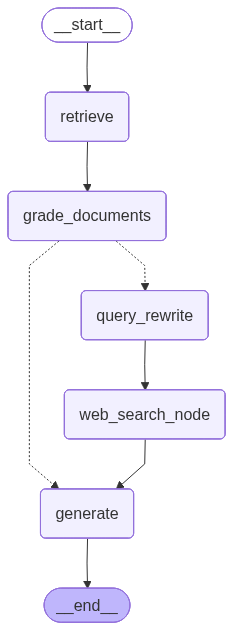

[retrieve] → ['documents']
{'documents': [Document(id='08087b2c-7025-42cb-adf7-e17b8d16a60b', metadata={'producer': 'Hancom PDF 1.3.0.542', 'creator': 'Hwp 2018 10.0.0.13462', 'creationdate': '2023-12-08T13:28:38+09:00', 'source': 'SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'SPRI_AI_Brief_2023년12월호_F.pdf', 'total_pages': 23, 'format': 'PDF 1.4', 'title': '', 'author': 'dj', 'subject': '', 'keywords': '', 'moddate': '2023-12-08T13:28:38+09:00', 'trapped': '', 'modDate': "D:20231208132838+09'00'", 'creationDate': "D:20231208132838+09'00'", 'page': 12}, page_content='SPRi AI Brief |  \n2023-12월호\n10\n삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개\nn 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성 \nAI 모델 ‘삼성 가우스’를 공개\nn 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한 \n삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유\nKEY Contents\n£ 언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원\nn 삼성전자가 2023년 11월 8일 열린 ‘삼성 AI 포럼 2023’ 행사에서 자체 개발한 생성 AI 모델 \n‘삼성 가우스’를 최초 공개\n∙정규분포 이론을 정립한 천재 수학자 가우스(Gauss)의 이름을 본뜬 삼성 가우스

In [27]:
# 1. 상태 만들고

# 2. 노드함수 생성하고 상태엣지함수 생성하고

# 3. 상태 그래프 만들고
workflow = StateGraph(State03)

# 4. 상태 그래프에 노드 추가하고
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("query_rewrite", query_rewrite)
workflow.add_node("web_search_node", web_search)

# 5. 엣지로 노드 연결하고
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges("grade_documents",
                               decide_to_generate,
                               {
                                   "query_rewrite": "query_rewrite",
                                   "generate": "generate"
                               })
workflow.add_edge("query_rewrite", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# 6. 컴파일하고
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

# 7. 시각화해서 확인하고 (스킵가능)
display(Image(app.get_graph().draw_mermaid_png()))

# 8. 그래프 실행
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": str(uuid.uuid4())})

inputs = {"question": "삼성전자가 개발한 생성형 AI 의 이름은?",}

for step in app.stream(inputs, config=config):
    # step은 {"노드명": {변경된_상태키: 값, ...}} 형태로 옴
    for node, payload in step.items():
        print(f"[{node}] → {list(payload.keys())}")
        # 필요하면 자세히:
        print(payload)

# 마지막 상태 한 번 더 받고 싶으면
print('\n\n')
final_state = app.get_state(config).values
print(final_state["generation"])

In [ ]:
result = app.invoke(inputs, config=config)
print(result["generation"])  # 최종 답변만 출력


In [ ]:
from langchain_teddynote.messages import stream_graph, invoke_graph
stream_graph(
    app,
    inputs,
    config,
    ["retrieve", "grade_documents", "query_rewrite", "web_search_node", "generate"],
)